In [ ]:
import os
import pandas as pd
import torch
from torch import nn
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from torch.nn import functional as F
from d2l import torch as d2l
from torch.utils.data import DataLoader

In [ ]:
pip install d2l==1.0.0a1.post0

We have created a copy of our dataset in our google drive. Afeter that, we have linked our drive to google colab in order to download the dataset.
Our dataset contains 7023 images of human brain MRI images which are classified into four categories:


1.   glioma;
2.   meningioma;

1.   no tumor;
2.   pituitary

The application of deep learning approaches in context to improve health diagnosis is providing impactful solutions. Our goal is to implement a convolutional neural network (CNN) to classify correctly whether a patient has or not the tumor and in case he has it, corrrectly classify what kind of tumor he has between the types mentioned above.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/drive/MyDrive/Machine Learning progetto/Training' '/content/'
!cp -r '/content/drive/MyDrive/Machine Learning progetto/Testing' '/content/'

With the following code, we loaded our image dataset from a training directory using PyTorch, and the DataLoader function allows us to manage the access to our batch data and facilitate training of machine learning models.

In [ ]:
my_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Machine Learning progetto/Training')
train_dataset = DataLoader(my_dataset,batch_size=32,shuffle=True,num_workers=2)

Through the DataFrame function we have created a DataFrame pandas containing image paths and their labels from a training directory. Each subdirectory in the root directory represents a class of images. The resulting DataFrame is useful for analysis and training of machine learning models.

In [ ]:
def DataFrame(path):
    images = []
    labels = []
    for subfolder in os.listdir(path):
        subfolder_path = os.path.join(path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_filename)
            images.append(image_path)
            labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df
train_df=DataFrame('/content/drive/MyDrive/Machine Learning progetto/Training')
train_df

,image,label
0,/content/drive/MyDrive/Machine Learning proget...,glioma
1,/content/drive/MyDrive/Machine Learning proget...,glioma
2,/content/drive/MyDrive/Machine Learning proget...,glioma
3,/content/drive/MyDrive/Machine Learning proget...,glioma
4,/content/drive/MyDrive/Machine Learning proget...,glioma
...,...,...
5737,/content/drive/MyDrive/Machine Learning proget...,pituitary
5738,/content/drive/MyDrive/Machine Learning proget...,pituitary
5739,/content/drive/MyDrive/Machine Learning proget...,pituitary
5740,/content/drive/MyDrive/Machine Learning proget...,pituitary


from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

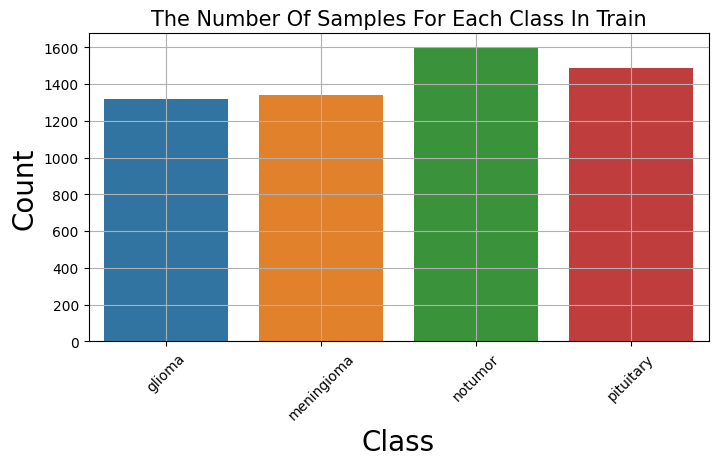

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_df.label)
plt.xlabel("Class", fontsize=20)
plt.title("The Number Of Samples For Each Class In Train", fontsize=15)
plt.ylabel('Count', fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
fig = px.pie(train_df, names='label', title="The % Of Samples For Each Class In Train", hole=0.3)

# Personalizzazione delle etichette
fig.update_traces(textinfo='percent+label', pull=[0.01, 0.1, 0.1], marker=dict(colors=['blue', 'green', 'red']))

fig.show()

In the two plots above we can see the total number and percentages respectively of images with pituitary,meningioma,glioma and no tumor.

Here we have converted the numeric label indeces with their name in the dataset

In [ ]:
def get_labels(labels):
    text_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
    return [text_labels[int(i)] for i in labels]

This part of the code below prepares the training dataset, applying a data augmentation transformation to improve data variability and using a DataLoader which is a pytorch function used to upload data from a dataset and provides an iterator that produces minibatches of data during training.

In [ ]:
data_augmentation = transforms.Compose([
        transforms.Resize((200,200)),
        transforms.ToTensor(),
    ])
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
generator = torch.Generator()
generator.manual_seed(seed)
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Machine Learning progetto/Training',transform=data_augmentation)
train_loader =DataLoader(train_dataset,batch_size=128, shuffle=True,num_workers=2,generator=generator)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Machine Learning progetto/Testing',transform=data_augmentation)
test_loader=DataLoader(test_dataset,batch_size=128,shuffle=True,num_workers=2,generator=generator)

Here, we created the show_image function to display a set of images in a grid, transposing the axis order to fit the format required by Matplotlib. We then used it to display a batch of images extracted from a DataLoader.

In [ ]:
def show_images(img, rows, cols, scale=2, titles=None):
    figsize = (scale * cols, scale * rows)
    _, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, img)):
        ax.imshow(np.transpose(img,(1,2,0))) #np.transpose(img, (1, 2, 0)): Questa parte del codice trasposta
        #l'array img per riorganizzare gli assi. L'array delle immagini di PyTorch ha l'ordine degli assi (canali, altezza, larghezza),
        #mentre Matplotlib richiede un ordine diverso, ovvero (altezza, larghezza, canali).
        #Quindi, questa trasposizione scambia l'ordine degli assi in modo che l'asse dei canali diventi l'ultimo.
        ax.axis('off')
        if titles is not None:
            ax.set_title(titles[i])
    plt.subplots_adjust(wspace=0.05)


torch.Size([32, 3, 600, 600]) torch.int64


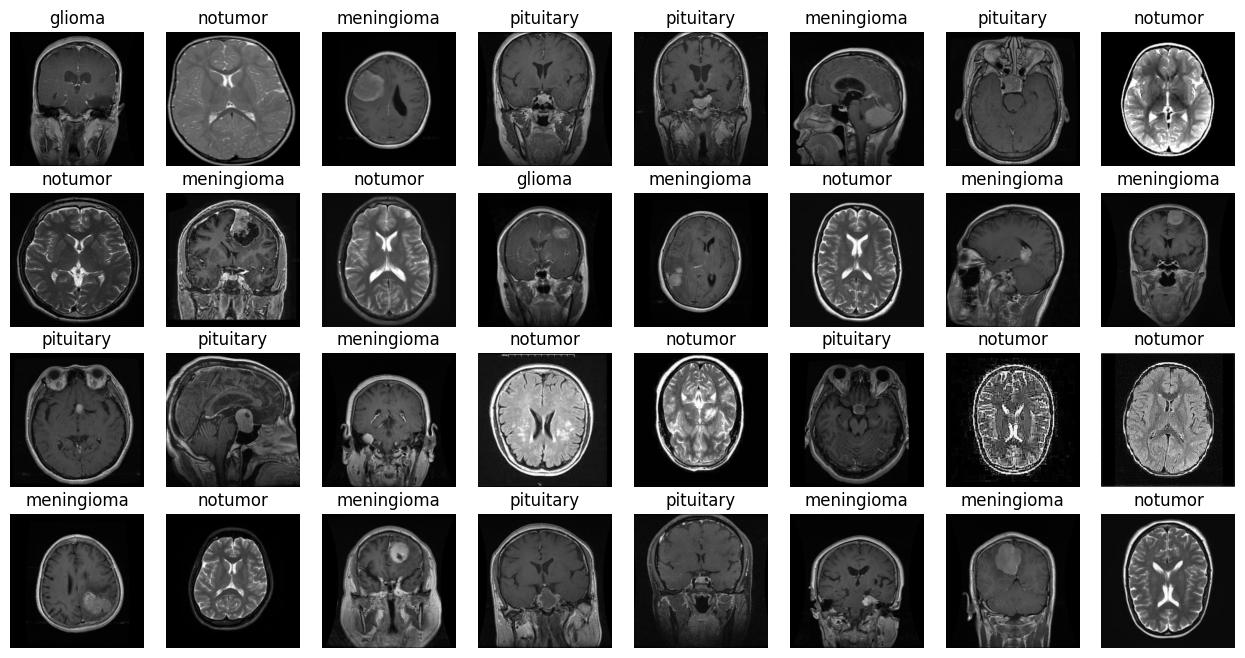

In [ ]:
for imgs, labels in train_loader:
    print(imgs.shape,labels.dtype)
    show_images(imgs, 4, 8, titles=get_labels(labels))
    break

Hence, in the plot above, we can see a batch of images of our dataset with their respective classification.

GOOGLENET

The GoogLeNet, also known as Inception v1, is a deep convolutional neural network (CNN) architecture designed for image classification and consists of 9 inception blocks.
The inception block consists of four parallel branches.The first three branches use convolutional layers with window sizes of $1x1$, $3x3$ and $5x5$ to extract information from different spatial sizes. The middle two branches also add a convolution of the input to reduce the number of channels, reducing the model’s complexity. The fourth branch uses a max-pooling layer, followed by a convolutional layer to change the number of channels. The four branches all use appropriate padding to give the input and output the same height and width. Finally, the outputs along each branch are concatenated along the channel dimension and comprise the block’s output.
As mentioned before, GoogLeNet uses a stack of a total of $9$ inception blocks, arranged into three groups with max-pooling in between, and global average pooling in its head to generate its estimates. Max-pooling between inception blocks reduces the dimensionality. The first module uses a $64-channel$ followed by a $7x7$ convulational layer. The second module uses a $2$ convulational layer: fisrt a $64-channel$ and $1x1$ convulational layer followed by a 3x3 that triples the number of the channels. At this poin we have $192$ channels. The third module connects two complete inception blocks in series and the output of the first inception block is: $64+128+32+32$ while the output of the second inception block is $128+192+96+64$. The fourth module is more complicated since it connects $5$ inception blocks in series. The last block, the 5-th one, ha two inception blocks output and it uses the global average pooling $nn.AdaptiveAvgPool2d((1,1))$ to change the height and width of each channel to $1$. Finally, we can turn the output into a two_dimensional array using $nn.Flatten()$, followed by a fully connected layer whose numer of outputs is the number of labelels classes in our dataset.
However, with the aim to reach a better result as far as the test accuracy is concerned, we have been forced to make some changes in the network introducing the residual network we implemented below.


---
inception.svg

Inception block


---

inception-full-90.svg

Google net model

In [ ]:
class Inception(nn.Module):
    def __init__(self, init_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)

        self.p1 = nn.Sequential(nn.Conv2d(init_channels, c1, kernel_size=1),nn.BatchNorm2d(c1),nn.ReLU())
        self.p2_1 = nn.Sequential(nn.Conv2d(init_channels, c2[0], kernel_size=1),nn.BatchNorm2d(c2[0]),nn.ReLU())
        self.p2_2 = nn.Sequential(nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1),nn.BatchNorm2d(c2[1]),nn.ReLU())
        self.p3_1 = nn.Sequential(nn.Conv2d(init_channels, c3[0], kernel_size=1),nn.BatchNorm2d(c3[0]),nn.ReLU())
        self.p3_2 = nn.Sequential(nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2),nn.BatchNorm2d(c3[1]),nn.ReLU())
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Sequential(nn.Conv2d(init_channels, c4, kernel_size=1),nn.BatchNorm2d(c4),nn.ReLU())

    def forward(self, x):
        p1 = self.p1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))

        return torch.cat((p1, p2, p3, p4), dim=1)


In [ ]:
class Inception1(nn.Module):
    def __init__(self, init_channels, c1, c2, c3, c4,prob=0.5,**kwargs):
        super(Inception1, self).__init__(**kwargs)

        self.p1 = nn.Sequential(nn.Conv2d(init_channels, c1, kernel_size=1),nn.BatchNorm2d(c1),nn.ReLU())
        self.p2_1 = nn.Sequential(nn.Conv2d(init_channels, c2[0], kernel_size=1),nn.BatchNorm2d(c2[0]),nn.ReLU())
        self.p2_2 = nn.Sequential(nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1),nn.BatchNorm2d(c2[1]),nn.ReLU())
        self.p3_1 = nn.Sequential(nn.Conv2d(init_channels, c3[0], kernel_size=1),nn.BatchNorm2d(c3[0]),nn.ReLU())
        self.p3_2 = nn.Sequential(nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2),nn.BatchNorm2d(c3[1]),nn.ReLU())
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Sequential(nn.Conv2d(init_channels, c4, kernel_size=1),nn.BatchNorm2d(c4),nn.ReLU())
        #self.dropout=nn.Dropout2d(prob)

    def forward(self, x):
        p1 = self.p1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))

        return torch.cat((p1, p2, p3, p4), dim=1)

RESIDUAL NETWORK

Now we try to focus on a specific part of the network to provide a clear understanding of the residual network. We denote $x$ as the input and we assume that $f(x)$ is the desired underlying mapping we want to obtain. From the plot below, the portion within the dotted line box needs to learn the residual mapping $g(x)=f(x)-x$.The figure illustrates the residual block of ResNet, where the solid line carrying the layer input
to the addition operator is called a residual connection (or shortcut connection). With residual blocks, inputs can forward propagate faster through the residual connections across layers. In fact, the residual block can be thought of as a special case of the multi-branch Inception block: it has two branches one of which is the identity mapping.
Moreover,he residual block has two $3x3$ convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a $ReLU$ activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function. The network works in the following way:

*  ***Identity Mapping***: The main innovation is the use of a residual block, which consists of a shortcut connection (identity mapping) and a set of convolutional layers. Instead of learning the desired output, ResNet aims to learn the residual (the difference between the desired output and the input to the block).
*  ***Shortcut Connections***: The shortcut connection allows the input to bypass one or more layers and be directly added to the output of the residual block. This enables the gradient to flow directly through the shortcut connection during backpropagation, addressing the vanishing gradient problem.



---

Image.svg



In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, c1,c2, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, c1, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(c1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(c2)
        self.stride = stride
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

The batch normalization, we implemented in our network, is a popular and effective technique that consistently accelerates the convergence of deep networks. This technique conveys all three benefits: preprocessing, numerical stability, and regularization. Batch normalization is applied to individual layers, or optionally, to all of them: In each training iteration, we first normalize the inputs (of batch normalization) by subtracting their mean and dividing by their standard deviation, where both are estimated based on the statistics of the current minibatch. Next, we apply a scale coefficient and an offset to recover the lost degrees of freedom. The formula applied is the following:

$BN(x)=\gamma\cdot \frac{x-\widehat{u}\cdot \beta}{\widehat{\sigma}_{\beta}}+\beta$

Where $\widehat{u}_{\beta}$ is the sample mean and $\widehat{\sigma}_{\beta}$ is the sample standard deviation of the minibatch $\beta$. Applying standardization hence, the resulting minibatch has zero mean and unit variance. The choice of unit variance is arbitrary. We recover this degree of freedom by including an elementwise scale parameter $\gamma$ and a shift parameter $\beta$ that both need to be learned during the training process. An other possible advantage of this module is that it seems to allow for more aggressive learning rates. Moreover, $\widehat{u}_{\beta}$ and $\widehat{\sigma}_{\beta}$ are computed as it follows:

$\widehat{u}_{\beta}=\frac{1}{|\beta|} \underset{x \in \beta}{\sum}{x}$ and $\widehat{\sigma}_{\beta}=\frac{1}{|\beta|} \underset{x \in \beta}{\sum}{(x-\widehat{u}_{\beta})^2+\epsilon}$

We add a small constant $\epsilon>0$ to the variance estimate to ensure that we never attempt division by zero, even in cases where the empirical variance estimate might be very small or vanish








---












As far as our network is concerned, at the first stage, we have implemented the $google-net$ but, we got bad result for both the train and test accuracy. Hence, we decided to implement our network using a batchnormalization in each inceptionblock to stabilize and speed up the training process by providing a more consistent and standardized input to each layer. In this manner, we got a significative improvement in both the train and the test accuracy. However, the test accuracy was not as good as the train one. Moreover, as we can see from the graph there is a problem of overfitting since the trend of the test accuracy is much different and worse from the one of the train. For this reason we decided to make further changes.
First, we tried to introduced a dropout module at the end of each inception block with the aim to reduce the overfitting but we did not get the results we were looking for. Hence, we came up with the idea to introduce the $res-net$ in our network.The primary motivation for ResNet is not to address overfitting but instead preventing the vanishing problem of the gradient (When gradients become very small, it means that the updates to the model's parameters during backpropagation are minimal; as a result, the learning process becomes extremely slow, and the optimization algorithm struggles to make meaningful adjustments to the model's weights). However, the introduction of skip connections can have a regularizing effect. The identity mappings in the residual blocks allow the model to learn the identity function if needed, and this flexibility can help prevent overfitting by avoiding overly complex mappings that might not generalize well.
Thank to this properties we reduced overfitting and also improved the convergence of the loss function as we can see from the second plot below.
Specifically, we added two res-net: the first one between the first and the second module of the $googlenet$ and the second one between the last module of the $googlenet$ and before the last fully connected linear layer. Moreover,before inserting the output of the last $res-net$ into the last linear layer we used $nn.AdaptiveAvgPool2d((1,1))$ to simplify the output size of our images and then used the $nn.Flatten()$ function to flatten the the input tensor into a one dimensional array.
Finally the last fully connected layer will return us four output since we have four labeles in our dataset.



In [ ]:
b11=nn.Sequential(nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3),nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2,padding=1))
b_11res=nn.Sequential(ResidualBlock(64,32,64))
b22 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),nn.ReLU(),nn.Conv2d(64, 192, kernel_size=3, padding=1),nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b33=nn.Sequential(Inception1(192, 64, (96, 128), (16, 32), 32),
                   Inception1(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b44=nn.Sequential(Inception1(480, 192, (96, 208), (16, 48), 64),
                   Inception1(512, 160, (112, 224), (24, 64), 64),
                   Inception1(512, 128, (128, 256), (24, 64), 64),
                   Inception1(512, 112, (144, 288), (32, 64), 64),
                   Inception1(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b5=nn.Sequential(Inception1(832, 256, (160, 320), (32, 128), 128),
                 Inception1(832, 384, (192, 384), (48, 128), 128),
                  nn.AdaptiveAvgPool2d((1, 1)),nn.Flatten())
b55=nn.Sequential(Inception1(832, 256, (160, 320), (32, 128), 128),
                 Inception1(832, 384, (192, 384), (48, 128), 128))

res_b66=nn.Sequential(ResidualBlock(1024,832,1024), nn.AdaptiveAvgPool2d((1, 1)),nn.Flatten())
net=nn.Sequential(b11,b22,b33,b44,b5,nn.Linear(1024,4))
net1 = nn.Sequential(b11,b_11res, b22, b33, b44, b55, res_b66, nn.Linear(1024, 4))


Important to remind that in our networks we used $ReLU$ as activation function.
Each input is changed as it follows:

$f(x)=x^+=max(0,x)=\frac{x+|x|}{2}=\begin{align*}
    \begin{cases}
        x\quad if x>0 \\
        0\quad otherwise \\
    \end{cases}
\end{align*}$

Advantages:

* only about 50% of hidden units are activated
* Better gradient propagation

* Efficient computation: only comparison, addition and multiplication
* Scale-invariant:$max(0,\alpha x)=\alpha\cdot max(0,x)$ for $\alpha>=0$

Moreover, we initialized the weights using the 'Normal Xavier initialization'.
Weights are drawn from a normal distribution with mean 0 and a standard deviation $\sigma=\sqrt{\frac{2}{inputs+outputs}}$





In [ ]:
#code to show the dimension of each layer
for data in train_loader:
    input_data,_ = data
    for layer in net1:
        input_data = layer(input_data)
        print(layer.__class__.__name__, 'output shape:\t', input_data.shape)

For training the model we used the $Cross-Entropyloss$ and as optimization algorithm we implemented $Adam$.

***Croos Entropy-Loss***

The Cross Entropy-Loss is used in conjuntion with the softmax. The softmax function gives us a vector $\widehat{y}$ which can be interpreted as the estimated conditional probabilities of each class, where:

$\widehat y=softmax(o)$ where $\widehat{y}_i=\frac{exp(O_i)}{\sum_j{exp(O_j)}}\quad (1)$

Moreover, because the softmax operation preserves the ordering among its arguments, we do not need to compute the softmax to determine which class has been assigned the highest probability. Thus,

$\underset{j}{argmax}\enspace\widehat{y}_j=\underset{j}{argmax}\enspace o_j$

Now, considering a dataset with features $X$ the labeles $Y$ are represented using a one-hot encoding label vector. We can compare the estimates with the reality by checking how probable the actual classes are according to our model, given the features:

$P(Y|X)=\underset{i=1}{\overset{n}{\prod}} P(y^{(i)}|x^{(i)})$

$-logP(Y|X)=\underset{i=1}{\overset{n}{\sum}} -logP(y^{(i)}|x^{(i)})=\underset{i=1}{\overset{n}{\sum}} l(y^{(i)},\widehat y^{(i)})$, where for any pair of label $y$ and model prediction $\widehat y$ over $q$ classes, the loss function is


$l(y,\widehat y)=-\underset{j=1}{\overset{q}{\sum}}y_{j}log \widehat y_j\quad (2)$

Now, plugging the first formula inside 2 we get:

$l(y,\widehat y)=-\underset{j=1}{\overset{q}{\sum}}y_jlog \frac{exp(O_j)}{\underset{k=1}{\overset{q}{\sum}}exp(o_k)}=\underset{j=1}{\overset{q}{\sum}}y_j\cdot log \underset{k=1}{\overset{q}{\sum}}exp(o_k)-\underset{j=1}{\overset{q}{\sum}}y_j\cdot o_j=log\underset{k=1}{\overset{q}{\sum}}exp(o_k)-\underset{j=1}{\overset{q}{\sum}}y_j\cdot o_j$

Considering now the derivative with respect to any logit $o_j$, we get:

$\partial_{o_{j}}l(y,\widehat y)=\frac{exp(O_j)}{\underset{k=1}{\overset{q}{\sum}}exp(o_k)}-y_j=softmax(o)_j-y_j$

In other words, the derivative is the difference between the probability assigned by our model, as expressed by the softmax operation, and what actually happened, as expressed by elements in the one-hot label vector.
Now in a multiclass problem, combining cross-entropy and softmax we evoid calculating $exp(o_j)$, instead we use $o_j$ directly due to the canceling term in $log(exp(o_j))$. So, we have:

$log(\widehat{y_j})=log \frac{exp(O_j)}{\underset{k=1}{\overset{q}{\sum}}exp(o_k)}=log(exp(o_j))-log({\underset{k=1}{\overset{q}{\sum}}exp(o_k)})=o_j-log({\underset{k=1}{\overset{q}{\sum}}exp(o_k)})$

Moreover, instead of passing softmax probabilities $\widehat{y}_j$ into our new loss function, we will just pass $o_j$ called logits to the cross-entropy loss function of PyTorch. Basically, with nn.CrossEntropyLoss, we can directly pass the raw logits to the loss function, and it internally applies the softmax and computes the negative log likelihood loss.

In practice, the cross-entropy expects as input a raw of values that we get from the output of our network. On the other side, the true label $y$ is expected to be a class indeces (since in our data we have four classe $y$ can be $0,1,2,3$). According to the index, the algorithm will select authomatically the logits in the raw values which position correspond to the index of the label. Then the nn.crossentropyloss() will compute the negative logarithm of the selected value. This is done for all the raw values that we got from our model and the average of those negative logarithm will be the loss.

---



***Mini Batch-Stochastic Gradient Descendent algorithm***

Before defining the mini batch gradient descendent is important to remind the functionality of the **gradient descendent** and the **batch gradient descendent**. The first has the goal to minimize the loss function performing two steps iteratively:


1. Compute the slope (gradient) that is the first-order derivative of the function at the current point
2. Move-in the opposite direction of the slope increase from the current point by the computed amount

The idea is to pass the training set through the hidden layers of the neural network and then update the parameters of the layers by computing the gradients using the training samples from the training dataset.

In **Batch Gradient Descent**, all the training data is taken into consideration to take a single step. Basically, we take the average of the gradients of all the training examples and then use that mean gradient to update our parameters.But, training all the data at once can be a problem if in our dataset we have a huge number of observations. So, one solution could be using the **stochastic gradient descendent** where we consider just one example at a time to take a single step. Howevere, with huge amount of data we may end up with a fluctuation of the cost function the more the latter reaches the minima. So, it will never reach it but it fluctuates around it. Moreover, since in SGD we use only one example at a time, we cannot implement the vectorized implementation. This can slow down the computations. To tackle this problem, a mixture of Batch Gradient Descent and SGD is used.
Neither we use all the dataset all at once nor we use the single example at a time. We use a batch of a fixed number of training examples which is less than the actual dataset and call it a mini-batch. Doing this helps us achieve the advantages of both gradient descendent and batch gradient descendent. So, after creating the mini-batches of fixed size, we do the following steps in one epoch:

1. Pick a mini-batch;
2. Feed it to a Neural Network;

1. Compute the mean gradient of the mini-batch
2. Used the updated mean of the gradient to update the weights







In particular the gradient is computed as it follows:

$g_k=\partial_w \frac{1}{|\beta_k|} \underset{j\in{\beta_k}}{\sum}f(x_i,w)$ where $\beta_k$ is the size of the bacth that has been previosly selected through the pytorch module DataLoader, $w$ are the weights and $x_i$ are the features in our dataset. Important to remind that since both $x_i$ and $\beta_k$ are drawn uniformly at random from the training set, the expectation of the gradient remains unchanged. The variance, on the other hand, is reduced significantly. Since the minibatch gradient is composed of $b\overset{\tiny{def}}{=}|\beta_t|$ independent gradients which are being averaged, its standard deviation is reduced by a factor of $b^{-\frac{1}{2}}$. This may indicate that choosing a large minibatch $\beta_t$ would be universally desirable. However, in practice we pick a minibatch that is large enough to offer good computational efficiency while still fitting into the memory of a GPU. In our case we selected at each iteration a batch of 128 observations.


















In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device #verificano se device è impostato.
            #se non lo fosse lo imposta sul primo parametro del modello
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required if doing the fine-tuning of BERT (recurrent network)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_normal_(m.weight) # Xavier parameter initialization: a particular method (see textbook section)
            nn.init.zeros_(m.bias)
    net.apply(init_weights)
    print('training on', device)

    net.to(device) # MOVE the net to the GPU (if available)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr,weight_decay=0.01)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],ylim=[0.3,0.9],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train() # Set the network to training mode (not evaluation mode)

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) #MOVE each minibatch of data to the GPU (if available)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            torch.cuda.empty_cache()
            with torch.no_grad(): # detach gradient calculation for avoiding effect on backpropagation calculation
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0]) #somma perdita ponderata x numero esempi, somma cumulata dell'accuratezza
                #previsionale
            timer.stop()

            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None)) #Condizione per aggiungere le metriche di addestramento
                             #al visualizzatore (animator). Questo avviene ogni 1/5 delle iterazioni o all'ultima iterazione di ogni epoca.
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [ ]:
import os

# Set the environment variable
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=528.00'

**GoogLeNet results**

loss 0.085, train acc 0.970, test acc 0.930
38.2 examples/sec on cuda:0


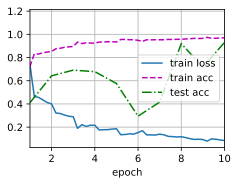

In [ ]:
d2l.train_ch6(net, train_loader, test_loader, 10, 0.1, device=d2l.try_gpu())

**GoogLeNet results with residual blocks**

loss 0.018, train acc 0.994, test acc 0.926
261.9 examples/sec on cuda:0


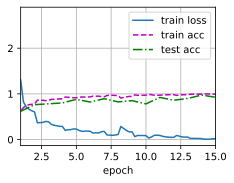

In [ ]:
d2l.train_ch6(net1, train_loader, test_loader, 15, 0.1, device=d2l.try_gpu())

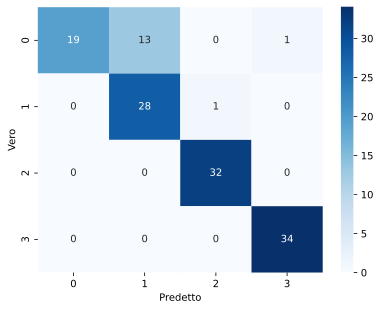

              precision    recall  f1-score   support

    Classe 0       1.00      0.58      0.73        33
    Classe 1       0.68      0.97      0.80        29
    Classe 2       0.97      1.00      0.98        32
    Classe 3       0.97      1.00      0.99        34

    accuracy                           0.88       128
   macro avg       0.91      0.89      0.88       128
weighted avg       0.91      0.88      0.88       128



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
net1.to(d2l.try_gpu())
true_labels = []
predicted_labels = []
for X, y in test_loader:
    X = X.to(d2l.try_gpu())
    y = y.to(d2l.try_gpu())
    break
y_pred = net1(X).argmax(axis=1)
true_labels.extend(y.cpu().numpy())
predicted_labels.extend(y_pred.cpu().numpy())
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predetto')
plt.ylabel('Vero')
plt.show()
print(classification_report(true_labels, predicted_labels, target_names=['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3']))

At the end, to better assess the accuracy of our model (using the googlenet+resnet), we created the cross-matrix where.

1. 0=glioma
2. 1=meningioma

1. 2=notumor
2. 3=pituitary







Analysing the results we may conclude our model works well. In fact our primary object was to correctly predict whether a person has or has not the tumor. From the plot above, which represents a batch of 128 prediction versus true condition of the patient, our model correctly predicted 32 cases of no tumor with only one case we predicted no tumor while instead the person has the tumor. However, as far as glioma is concerned, the result is a little bit misleading since it is confused by the model with meningioma 13 times and it  increases the false negative rate.

$precision=\frac{True Positive}{True Positive+False Positive}$-It represents the proportion of positive instances predicted correctly among all positive instances predicted. High precision indicates that the model has fewer false positives.

$recall=\frac{True Positive}{True Positive+False Negative}$-It represents the proportion of positive instances that were predicted correctly among all real positive instances. A high recall indicates that the model has fewer false negatives

$F1score=2\cdot \frac{precision\cdot recall}{precision+recall}$-harmonic mean between precision and recall.It provides a balance between precision and recall. The F1-score is especially useful if we want to account for both false positives and false negatives. Closer it is to one the better is the balance between precision and recall